In [ ]:
from grade_classif.imports import *
from grade_classif.params.parser import hparams
from grade_classif.models.plmodules import *
from grade_classif.data.read import get_items
from grade_classif.data.loaders import ImageLoader
from grade_classif.data.utils import np_to_tensor
from grade_classif.data.transforms import get_transforms1
from skimage.color import rgb2hed
from fastai.data.transforms import get_files
from torch.utils.data import Dataset, DataLoader
from fastcore.foundation import L

In [ ]:
data = Path('/data/DeepLearning/SCHWOB_Robin/Patches_normalized_299/Patches_normalized_299_1/')
files = get_files(data, extensions=['.png'])

In [ ]:
model = ClassifModel(
    n_classes=3,
    model="resnet34",
    loss="cross-entropy",
    level=1,
    gpus=[0],
    savedir="/home/DeepLearning/media/Isilon_robin/manually_classified_patches/logs",
)

/home/DeepLearning/grade_classif/nbs/grade_classif/models/utils.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(sizes)[idxs], np.array(mods)[idxs]


In [ ]:
model.load("d414446ad5a14ca49168588ccc7c330d", 1)

In [ ]:
model.freeze()

In [ ]:
class TestDataset(Dataset):
    def __init__(self, items):
        self.items = items.map(str)
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        item = self.items[idx]
        img = imread(item).astype(np.float32)
        return np_to_tensor(img / 255, "image")

In [ ]:
ds = TestDataset(files)

In [ ]:
dl = DataLoader(
    ds, batch_size=128, shuffle=False, num_workers=4, drop_last=False, pin_memory=True
)

In [ ]:
preds = []
for x in tqdm(dl):
    x = x.to(model.main_device, non_blocking=True)
    y = model.predict(x).detach()
    preds.extend(y.argmax(dim=1).cpu().numpy())

In [ ]:
preds = L(preds)

In [ ]:
slides = files.filter(lambda x: x.parts[-3] != '2').map(lambda x: x.parent.name).unique()

In [ ]:
colors = np.array([[0, 0, 255],
                   [255, 0, 0],
                   [0, 255, 0]])

In [ ]:
preds.argwhere(lambda x: x==1)

(#148588) [187,189,217,228,231,234,262,267,268,269...]

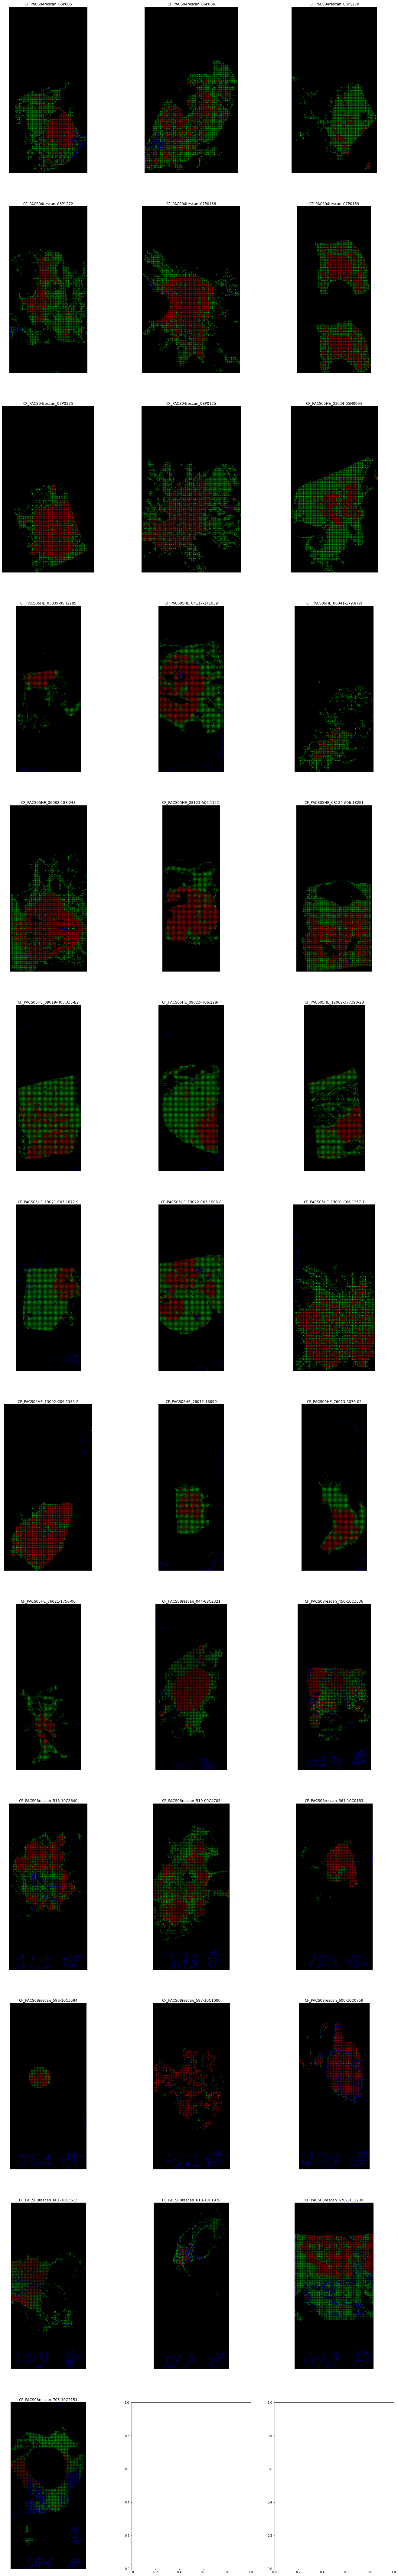

In [ ]:
ncols = 3
nrows = int(np.ceil(len(slides) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*12))
for ax, slide in tqdm(zip(axs.flatten(), slides), total=len(slides)):
    idxs = files.argwhere(lambda x: x.parent.name == slide)
    slide_preds = preds[idxs]
    slide_files = files[idxs]
    x_coords = slide_files.map(lambda x: int(x.stem.split('_')[-2]))
    y_coords = slide_files.map(lambda x: int(x.stem.split('_')[-1]))
    h = max(y_coords) // 299 + 1
    w = max(x_coords) // 299 + 1
    mask = np.zeros((h, w, 3), dtype = np.uint8)
    for pred, x, y in zip(slide_preds, x_coords, y_coords):
        mask[y//299, x//299] = colors[pred]
    ax.axis("off")
    ax.set_title(slide)
    ax.imshow(mask)

In [ ]:
#df = pd.read_csv(hparams.patch_classes, index_col='patchId')
def get_filt(ds):
    def filt(x):
        return ds in x.stem
    return filt

In [ ]:
p04_items, p04_labels = get_items(hparams.data, lambda x: x.parts[-3], extensions=['.png'], filterfunc = get_filt('PACS04'))

In [ ]:
p05_items, p05_labels = get_items(hparams.data, lambda x: x.parts[-3], extensions=['.png'], filterfunc = get_filt('PACS05'))

In [ ]:
p08_items, p08_labels = get_items(hparams.data, lambda x: x.parts[-3], extensions=['.png'], filterfunc = get_filt('PACS08'))

In [ ]:
hparams.open_mode = 'H'
hparams.transforms = 1
hparams.normalizer = 'cbr_5_32_4'
#hparams.loss = 'mse'
hparams.size = 299
hparams.gpus = [0]
hparams.filt = 'all'
hparams.batch_size = 16
hparams.patch_classes = None
hparams.norm_csv = None
hparams.concept_classes = None
hparams.level = 4
hparams.loss = 'mse'
# hparams.train_percent = 0.01
hparams.data = Path('/data/DeepLearning/SCHWOB_Robin/Patches_normacolor_299/Patches_299_4')
hparams.data_csv = Path('/home/DeepLearning/grade_classif/csvs/normacolor_scans.csv')

In [ ]:
norm = Normalizer(hparams)

In [ ]:
dm = NormDataModule(hparams)

In [ ]:
dm.setup()

In [ ]:
norm.fit(dm)

In [ ]:
norm.load('1371a8451df344689f213e8db008ed71')

In [ ]:
norm.freeze()

In [ ]:
dm.data.valid._ds.items = p04_items
dm.data.valid._ds.labels = p04_items

In [ ]:
norm.data.test = norm.data.valid

In [ ]:
len(dm.data.valid)

0

In [ ]:
l = np.random.randint(len(dm.data.valid), size=64)

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(40, 40))
for n, ax1 in enumerate(axs):
    x = []
    for i in range(8):
        k = l[8*n+i]
        img, _ = dm.data.valid[k]
        x.append(img)
    x = torch.stack(x).to(norm.main_device)
    #x = _open_functions[norm.hparams.open_mode](x)
    x = norm.predict(x).detach().clamp(0, 1)
    x = x.cpu().numpy().transpose(0, 2, 3, 1)
    for im, ax in zip(x, ax1):
        ax.imshow(im)
        ax.axis('off')

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(40, 40))
for n, ax in enumerate(axs.flatten()):
    k = l[n]
    _, img = dm.data.valid[k]
    img = img.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')

In [ ]:
norm.show_results(16, 6)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(24, 16))
fn = np.random.choice(p08_items)
x = loader(fn)[362:661, 362:661]
axs[0, 0].imshow(x)
axs[0, 0].axis('off')
for ax in axs.flatten()[1:]:
    x = rgb2hed(x)[..., 0].astype(np.float32)
    x = (x + 0.7) / 0.46
    x = np.stack((x, x, x), axis=-1)
    x = np_to_tensor(x, 'image')[None]
    x = x.to(norm.main_device)
    x = norm.predict(x).detach().clamp(0, 1)
    x = x.cpu().numpy().transpose(0, 2, 3, 1)[0]
    ax.imshow(x)
    ax.axis('off')

In [ ]:
from albumentations import CenterCrop

In [ ]:
patch_classes_df = pd.read_csv('/data/DeepLearning/SCHWOB_Robin/Patches_1024/Patches_1024_1/patch_classes.csv', index_col='patchId')
def filt(x):
    return patch_classes_df.loc[x.stem, 'type'] == 'K'

data = (ImageClassifDataset.
        from_folder(Path('/data/DeepLearning/SCHWOB_Robin/Patches_299/Patches_299_1/'), lambda x: x.parts[-3], classes=['1', '3'], extensions=['.png'], open_mode='RGB').
        split_by_csv(hparams.data_csv.parent/'scans.csv').
        to_tensor(tfm_y=False))

In [ ]:
fig, axs = plt.subplots(8, 2, figsize=(10, 40))
batch = []
for _ in axs:
    i = np.random.randint(len(data.train))
    im, _ = data.train[i]
    batch.append(im)
x = torch.stack(batch).to(norm.main_device)
y = norm.predict(x).clamp(0, 1).detach().cpu()
for ax, im, pred in zip(axs, batch, y):
    im = im.numpy().transpose(1, 2, 0)
    pred = pred.numpy().transpose(1, 2, 0)
    ax[0].imshow(im)
    ax[0].axis('off')
    ax[1].imshow(pred)
    ax[1].axis('off')